In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import multivariate_normal
from scipy.stats import norm
from numpy import random as rd
from scipy import stats

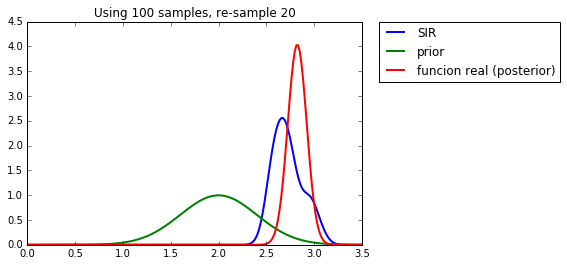

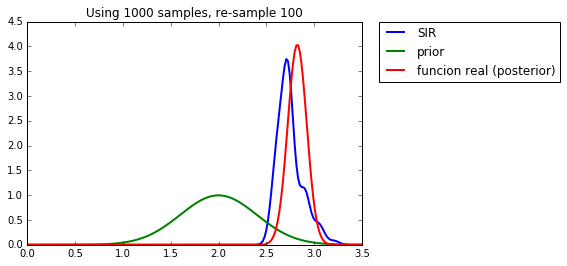

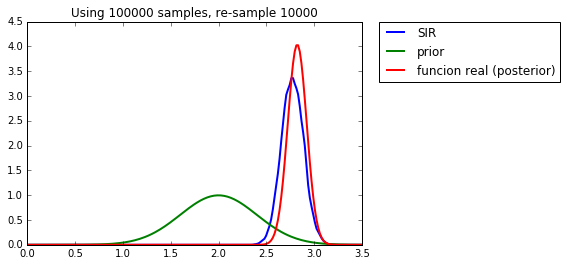

In [7]:
mu = 3
var = 0.5
sig = np.sqrt(var)
N = 50
y = rd.normal(mu, sig, N)

mu0 = 2
sig0 = 0.4

# Estimation of mean with knonw variance
# Use a gaussian conjugate prior
def posterior(mu0, s20, s2, X, n):
    muml = np.sum(X[0 : n]) / n
    mun = (s2 * mu0 / (n * s20 + s2)) +  n * s20 * muml / (n * s20 + s2)
    sign = 1.0 / ((1.0 / s20) +  (n / s2))
    return mun, sign

muk, sigk = posterior(mu0, sig0, var, y, len(y))


def fun(mu, sigu):
    N = len(y)
    a = 1.0 / ((2.0 * np.pi * sigu) ** (N / 2.0))
    b = -np.sum((y - mu) ** 2) / (2.0 * sigu)
    c = a * np.exp(b)
    return c

fun_vec = np.vectorize(fun)

def q(z):
    return norm.pdf(z, mu0, sig0)

def draw_q(n):
    return rd.normal(mu0, sig0, size=n)

def pt(z):
    return fun_vec(z, sig) * q(z)
    
def pz(z): # Posterior
    return norm.pdf(z, muk, np.sqrt(sigk))

def comp_w(n):
    s = draw_q(n)
    w = pt(s) / q(s)
    den = np.sum(w)
    w = w / den
    assert (abs(np.sum(w) - 1) < 1e-10)
    return s, w


Nexp = [100, 1000, 100000]
Nrem = [20, 100, 10000]

for k in range(len(Nexp)):
    n = Nexp[k]
    r = Nrem[k]
    s,w = comp_w(n)
    accu = np.copy(w)
    for i in range(1, n):
        accu[i] += accu[i - 1]
    
    samples = []
    for i in range(r):
        index = np.searchsorted(accu, rd.uniform())
        samples.append(s[index])
    
    kernel = stats.gaussian_kde(samples)
    # plt.plot(s, w, '.')
    x = np.linspace(0, 3.5, 200)
    plt.plot(x, kernel(x), label='SIR', lw=2)
    plt.plot(x, q(x), label='prior', lw=2)
    plt.plot(x, pz(x), label='funcion real (posterior)', lw=2)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title('Using %d samples, re-sample %d' % (n, r))
    plt.show()